In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import chi2

# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/ntnu-testimon/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

In [2]:
# Your code here
Fraud = pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [3]:
Fraud.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [4]:
Fraud.head(5)
# Step - Maps a unit of time in the real world. In this case 1 step is 1 hour of time.

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
Fraud.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [6]:
Fraud_rnd_sample = Fraud.sample(n=100000, random_state=1)

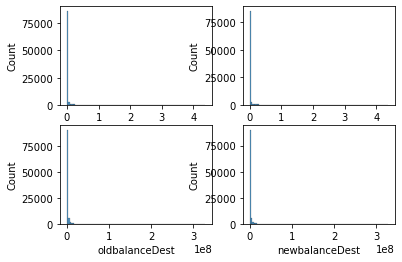

In [7]:
fig, axs = plt.subplots(2, 2)
sns.histplot(Fraud_rnd_sample, x="oldbalanceOrg", bins = 100, ax = axs[0,0])
sns.histplot(Fraud_rnd_sample, x="newbalanceOrig", bins = 100,ax = axs[0,1])
sns.histplot(Fraud_rnd_sample, x="oldbalanceDest", bins = 100,ax = axs[1,0])
sns.histplot(Fraud_rnd_sample, x="newbalanceDest", bins = 100,ax = axs[1,1])
plt.show()

# Brutally skewed.
# Also olds with exact zeros removed. Very skewed to low values nonetheless.

In [8]:
print('0s Rate - oldbalanceOrg:',round(100*len(Fraud[Fraud['oldbalanceOrg'] == 0])/len(Fraud),2),'%')
print('0s Rate - newbalanceOrig:',round(100*len(Fraud[Fraud['newbalanceOrig'] == 0])/len(Fraud),2),'%')
print('0s Rate - oldbalanceDest:',round(100*len(Fraud[Fraud['oldbalanceDest'] == 0])/len(Fraud),2),'%')
print('0s Rate - newbalanceDest:',round(100*len(Fraud[Fraud['newbalanceDest'] == 0])/len(Fraud),2),'%')

0s Rate - oldbalanceOrg: 33.04 %
0s Rate - newbalanceOrig: 56.73 %
0s Rate - oldbalanceDest: 42.5 %
0s Rate - newbalanceDest: 38.34 %


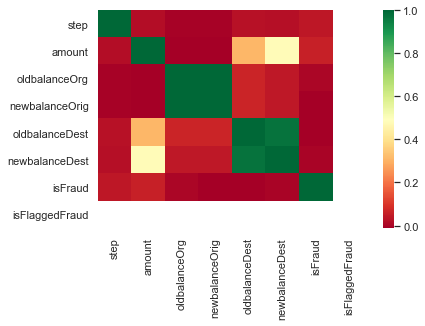

In [9]:
corr = Fraud_rnd_sample.corr()
sns.set_theme(style="white")
sns.heatmap(corr, cmap = plt.cm.RdYlGn)
plt.show()

In [10]:
Fraud_rnd_sample['type'].value_counts().reset_index()

,index,type
0,CASH_OUT,35209
1,PAYMENT,33694
2,CASH_IN,21987
3,TRANSFER,8416
4,DEBIT,694


### What is the distribution of the outcome? 

In [11]:
print('Fraud Count:',len(Fraud[Fraud['isFraud'] == 1]))
print('Not Fraud Count:',len(Fraud[Fraud['isFraud'] == 0]))
print('Fraud Rate:',round(100*len(Fraud[Fraud['isFraud'] == 1])/len(Fraud),2),'%')

Fraud Count: 8213
Not Fraud Count: 6354407
Fraud Rate: 0.13 %


### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [12]:
### On the step, maybe the time of the day is important. 
### If 1 represents one given starting hour, we can do the modulo of 24 and get the hour of the day and do dummies.
Fraud_clean = Fraud
Fraud_clean['Step_Modulo_24'] = Fraud_clean['step'].mod(24)

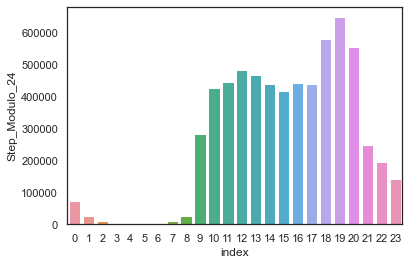

In [13]:
sns.barplot(x = Fraud_clean['Step_Modulo_24'].value_counts().reset_index()["index"],y = Fraud_clean['Step_Modulo_24'].value_counts().reset_index()["Step_Modulo_24"])
plt.show() 
### Yeah, that seems to make sense... It might even be that the step modulo matches with the real hour...
### It does look like people are mostly asleep from 2am to 6am, that sounds OK to me.

In [14]:
Fraud_clean['nameOrig_first_char'] = Fraud_clean['nameOrig'].astype(str).str[0]
Fraud_clean['nameOrig_first_char'].value_counts() ### Just 'C', will drop this.

Fraud_clean['nameDest_first_char'] = Fraud_clean['nameDest'].astype(str).str[0]
Fraud_clean['nameDest_first_char'].value_counts() ### Two different accounts, will dummy this.

Fraud_clean['nameOrig_len'] = Fraud_clean['nameOrig'].str.len()
Fraud_clean['nameDest_len'] = Fraud_clean['nameDest'].str.len()

In [15]:
Fraud_clean['nameOrig_len'].value_counts() ### Might just do 11, 10 and Other.

11    3398630
10    2667372
9      266807
8       26789
7        2718
6         269
5          35
Name: nameOrig_len, dtype: int64

In [16]:
replace_dict = {11:11,10:10,9:'Other',8:'Other',7:'Other',6:'Other',5:'Other'}
Fraud_clean.replace({"nameOrig_len": replace_dict}, inplace = True)
replace_dict = {11:11,10:10,9:'Other',8:'Other',7:'Other',6:'Other',5:'Other',4:'Other',2:'Other'}
Fraud_clean.replace({"nameDest_len": replace_dict}, inplace = True)

In [17]:
Fraud_clean = pd.get_dummies(Fraud_clean, columns=['Step_Modulo_24','type','nameOrig_len','nameDest_len','nameDest_first_char'])

In [18]:
Fraud_clean = Fraud_clean.drop(['nameOrig_first_char','nameOrig','nameDest','step'], axis =1)

In [19]:
# Your code here
y = Fraud_clean["isFraud"]
x = Fraud_clean.drop('isFraud', axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2,random_state=15) 

In [20]:
# Normalize amounts of money (amount, oldbalancedOrg, newbalanceOrig, oldbalanceDest, newbalanceDest)
def scale_func(x):
    mymax = np.max(x)
    mymin = np.min(x)
    myamplitude = mymax - mymin
    mylist = []
    for ele in x:
        mylist.append((ele - mymin)/myamplitude)
    return mylist

warnings.filterwarnings("ignore")

warnings.filterwarnings("ignore")
x_train['amount_scaled'] = scale_func(x_train['amount'])
x_train['oldbalanceOrg_scaled'] = scale_func(x_train['oldbalanceOrg'])
x_train['oldbalanceDest_scaled'] = scale_func(x_train['oldbalanceDest'])
x_train['newbalanceOrig_scaled'] = scale_func(x_train['newbalanceOrig'])
x_train['newbalanceDest_scaled'] = scale_func(x_train['newbalanceDest'])

x_test['amount_scaled'] = scale_func(x_test['amount'])
x_test['oldbalanceOrg_scaled'] = scale_func(x_test['oldbalanceOrg'])
x_test['oldbalanceDest_scaled'] = scale_func(x_test['oldbalanceDest'])
x_test['newbalanceOrig_scaled'] = scale_func(x_test['newbalanceOrig'])
x_test['newbalanceDest_scaled'] = scale_func(x_test['newbalanceDest'])
warnings.filterwarnings("default")

x_train = x_train.drop(['amount','oldbalanceOrg','oldbalanceDest','newbalanceOrig','newbalanceDest'], axis =1)
x_test = x_test.drop(['amount','oldbalanceOrg','oldbalanceDest','newbalanceOrig','newbalanceDest'], axis =1)

warnings.filterwarnings("default")

### Run a logisitc regression classifier and evaluate its accuracy.

In [21]:
# Your code here
model = LogisticRegression(max_iter=1000)
model = model.fit(x_train, y_train)

print("Test accuracy:", model.score(x_test,y_test))
print("Train accuracy:", model.score(x_train, y_train))

y_pred = model.predict(x_test)
score = f1_score(y_test, y_pred, average='binary')

# print("Classification report:", classification_report(y_pred,y_test))
# print("Accuracy Score:", accuracy_score(y_test, y_pred))
# print("Confusion Matrix:", confusion_matrix(model.predict(x_test),y_test))
# print("Test data accuracy:", model.score(x_test,y_test))
print("Train data accuracy:", model.score(x_train, y_train))
print('F-Measure: %.3f' % score)

scores, pvalues = chi2(x_train, y_train)
print('p-values',pvalues)

##### It does look amazing in terms of accuracy, but the confusion matrix reveals that the model is 
##### rather bad with dealing with the fraud cases, which is actually what we want.
##### it just happens that they are a very small part of the sample... 
##### This is reflected in the very iffy f1 score.

Test accuracy: 0.9988998242862217
Train accuracy: 0.9989078791441262
Train data accuracy: 0.9989078791441262
F-Measure: 0.328
p-values [0.00000000e+000 1.51909166e-087 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 1.31766066e-001 4.52212841e-012
 6.90609563e-021 1.83422086e-023 4.21878002e-020 3.06585572e-014
 1.05473642e-014 1.71984644e-018 9.93794278e-015 6.48328151e-042
 9.84092335e-055 2.12475643e-037 2.48777633e-001 6.35928764e-008
 1.27218252e-019 0.00000000e+000 5.09402475e-092 5.88778202e-011
 0.00000000e+000 0.00000000e+000 3.84094262e-001 4.88609337e-001
 7.90967409e-001 5.43590474e-001 5.17793762e-001 7.14116048e-001
 4.80364742e-250 0.00000000e+000 3.18727322e-142 2.61499473e-020
 2.33605360e-002 1.22157340e-016 8.59145276e-001]


### Now pick a model of your choice and evaluate its accuracy.

In [23]:
# Will do the same model, but with downsampling of the majority (not fraud)
# There is no data problem, the dataset is big.
NotFraud = Fraud_clean[Fraud_clean['isFraud'] == 0]
Fraud = Fraud_clean[Fraud_clean['isFraud'] == 1]

NotFraud_downsampled = resample(NotFraud,replace=True,n_samples=len(Fraud),random_state=15)
Fraud_clean_downsampled = Fraud.append(NotFraud_downsampled)

y = Fraud_clean_downsampled["isFraud"]
x = Fraud_clean_downsampled.drop('isFraud', axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2,random_state=15) 

warnings.filterwarnings("ignore")
x_train['amount_scaled'] = scale_func(x_train['amount'])
x_train['oldbalanceOrg_scaled'] = scale_func(x_train['oldbalanceOrg'])
x_train['oldbalanceDest_scaled'] = scale_func(x_train['oldbalanceDest'])
x_train['newbalanceOrig_scaled'] = scale_func(x_train['newbalanceOrig'])
x_train['newbalanceDest_scaled'] = scale_func(x_train['newbalanceDest'])

x_test['amount_scaled'] = scale_func(x_test['amount'])
x_test['oldbalanceOrg_scaled'] = scale_func(x_test['oldbalanceOrg'])
x_test['oldbalanceDest_scaled'] = scale_func(x_test['oldbalanceDest'])
x_test['newbalanceOrig_scaled'] = scale_func(x_test['newbalanceOrig'])
x_test['newbalanceDest_scaled'] = scale_func(x_test['newbalanceDest'])
warnings.filterwarnings("default")

x_train = x_train.drop(['amount','oldbalanceOrg','oldbalanceDest','newbalanceOrig','newbalanceDest'], axis =1)
x_test = x_test.drop(['amount','oldbalanceOrg','oldbalanceDest','newbalanceOrig','newbalanceDest'], axis =1)

model = LogisticRegression(max_iter=1000)
model = model.fit(x_train, y_train)

print("Test accuracy:", model.score(x_test,y_test))
print("Train accuracy:", model.score(x_train, y_train))

y_pred = model.predict(x_test)
score = f1_score(y_test, y_pred, average='binary')

# print("Classification report:", classification_report(y_pred,y_test))
# print("Accuracy Score:", accuracy_score(y_test, y_pred))
# print("Confusion Matrix:", confusion_matrix(model.predict(x_test),y_test))
# print("Test data accuracy:", model.score(x_test,y_test))
print("Train data accuracy:", model.score(x_train, y_train))
print('F-Measure: %.3f' % score)

scores, pvalues = chi2(x_train, y_train)
pvalues_train = ["{0:.7f}".format(x)for x in pvalues]
scores, pvalues = chi2(x_test, y_test)
pvalues_test = ["{0:.7f}".format(x)for x in pvalues]

for i in range(len(x_train.columns)):
    print(x_train.columns[i],"-->",pvalues_train[i],"||",pvalues_test[i]) 

### Will then drop the len of the names.
### Tested dropping the destination balances, but didn't change meaningfully the results, so kept them.
### Other things could be done, such as lumping the hours of the day in subgroups... changing models...
### Never ending story if we wanted to go on and on.

Test accuracy: 0.8737066342057213
Train accuracy: 0.8558599695585997
Train data accuracy: 0.8558599695585997
F-Measure: 0.874
isFlaggedFraud --> 0.0002917 || 0.0891924
Step_Modulo_24_0 --> 0.0000000 || 0.0000010
Step_Modulo_24_1 --> 0.0000000 || 0.0000000
Step_Modulo_24_2 --> 0.0000000 || 0.0000000
Step_Modulo_24_3 --> 0.0000000 || 0.0000000
Step_Modulo_24_4 --> 0.0000000 || 0.0000000
Step_Modulo_24_5 --> 0.0000000 || 0.0000000
Step_Modulo_24_6 --> 0.0000000 || 0.0000000
Step_Modulo_24_7 --> 0.0000000 || 0.0000000
Step_Modulo_24_8 --> 0.0000000 || 0.0000000
Step_Modulo_24_9 --> 0.0388809 || 0.9771784
Step_Modulo_24_10 --> 0.0000000 || 0.0385753
Step_Modulo_24_11 --> 0.0000000 || 0.0000403
Step_Modulo_24_12 --> 0.0000000 || 0.0014903
Step_Modulo_24_13 --> 0.0000000 || 0.0022261
Step_Modulo_24_14 --> 0.0000000 || 0.0045052
Step_Modulo_24_15 --> 0.0000001 || 0.2384461
Step_Modulo_24_16 --> 0.0000000 || 0.0007443
Step_Modulo_24_17 --> 0.0000000 || 0.0000006
Step_Modulo_24_18 --> 0.0000000 

In [24]:
# Will do the same model, but with downsampling of the majority (not fraud)
# There is no data problem, the dataset is big.
NotFraud = Fraud_clean[Fraud_clean['isFraud'] == 0]
Fraud = Fraud_clean[Fraud_clean['isFraud'] == 1]

NotFraud_downsampled = resample(NotFraud,replace=True,n_samples=len(Fraud),random_state=15)
Fraud_clean_downsampled = Fraud.append(NotFraud_downsampled)

y = Fraud_clean_downsampled["isFraud"]
x = Fraud_clean_downsampled.drop('isFraud', axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2,random_state=15) 

warnings.filterwarnings("ignore")
x_train['amount_scaled'] = scale_func(x_train['amount'])
x_train['oldbalanceOrg_scaled'] = scale_func(x_train['oldbalanceOrg'])
x_train['oldbalanceDest_scaled'] = scale_func(x_train['oldbalanceDest'])
x_train['newbalanceOrig_scaled'] = scale_func(x_train['newbalanceOrig'])
x_train['newbalanceDest_scaled'] = scale_func(x_train['newbalanceDest'])

x_test['amount_scaled'] = scale_func(x_test['amount'])
x_test['oldbalanceOrg_scaled'] = scale_func(x_test['oldbalanceOrg'])
x_test['oldbalanceDest_scaled'] = scale_func(x_test['oldbalanceDest'])
x_test['newbalanceOrig_scaled'] = scale_func(x_test['newbalanceOrig'])
x_test['newbalanceDest_scaled'] = scale_func(x_test['newbalanceDest'])
warnings.filterwarnings("default")

x_train = x_train.drop(['amount','oldbalanceOrg','oldbalanceDest','newbalanceOrig','newbalanceDest','nameOrig_len_10','nameOrig_len_11','nameOrig_len_Other','nameDest_len_10','nameDest_len_11','nameDest_len_Other'], axis =1)
x_test = x_test.drop(['amount','oldbalanceOrg','oldbalanceDest','newbalanceOrig','newbalanceDest','nameOrig_len_10','nameOrig_len_11','nameOrig_len_Other','nameDest_len_10','nameDest_len_11','nameDest_len_Other'], axis =1)

model = LogisticRegression(max_iter=1000)
model = model.fit(x_train, y_train)

print("Test accuracy:", model.score(x_test,y_test))
print("Train accuracy:", model.score(x_train, y_train))

y_pred = model.predict(x_test)
score = f1_score(y_test, y_pred, average='binary')

# print("Classification report:", classification_report(y_pred,y_test))
# print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:", confusion_matrix(model.predict(x_test),y_test))
# print("Test data accuracy:", model.score(x_test,y_test))
print("Train data accuracy:", model.score(x_train, y_train))
print('F-Measure: %.3f' % score)

Test accuracy: 0.8740109555690809
Train accuracy: 0.8559360730593607
Confusion Matrix: [[1432  234]
 [ 180 1440]]
Train data accuracy: 0.8559360730593607
F-Measure: 0.874


### Which model worked better and how do you know?

In [25]:
# Your response here
# Second has a better F measure and more accuracy in dectecting the actual fraud cases, mostly coming from the downsampling

### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.